In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
# def load_images_from_folders(base_path):
#     """Recursively loads all images from subdirectories."""
#     image_paths = glob(os.path.join(base_path, "**", "*.jpg"), recursive=True)  # Modify for other image formats
#     print(f"Loaded {len(image_paths)} images from {base_path}")
#     return sorted(image_paths)

# def extract_edges(image):
#     """Applies Canny edge detection."""
#     edges = cv2.Canny(image, 100, 200)
#     return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)  # Convert to 3-channel

# def compute_dense_optical_flow(prev_image, next_image):
#     """Computes dense optical flow between two images."""
#     prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
#     next_gray = cv2.cvtColor(next_image, cv2.COLOR_BGR2GRAY)
#     flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
#     magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
#     hsv = np.zeros_like(prev_image)
#     hsv[..., 1] = 255
#     hsv[..., 0] = angle * 180 / np.pi / 2
#     hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
#     return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)


In [ ]:
# def prepare_data(real_faces, real_flow, fake_faces, fake_flow):
#     """Loads images, computes edges & optical flow."""
#     print("Preparing dataset...")
#     real_images = load_images_from_folders(real_faces)
#     fake_images = load_images_from_folders(fake_faces)
    
#     real_data, fake_data = [], []
#     for i in range(len(real_images) - 1):
#         img1 = cv2.resize(cv2.imread(real_images[i]), (299, 299))
#         img2 = cv2.resize(cv2.imread(real_images[i + 1]), (299, 299))
#         edge_map = extract_edges(img1)
#         flow_map = compute_dense_optical_flow(img1, img2)
#         real_data.append((img1, edge_map, flow_map))
    
#     for i in range(len(fake_images) - 1):
#         img1 = cv2.resize(cv2.imread(fake_images[i]), (299, 299))
#         img2 = cv2.resize(cv2.imread(fake_images[i + 1]), (299, 299))
#         edge_map = extract_edges(img1)
#         flow_map = compute_dense_optical_flow(img1, img2)
#         fake_data.append((img1, edge_map, flow_map))
    
#     print("Dataset prepared.")
#     return real_data, fake_data

In [3]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building model...")

    
    # Spatial Feature Extractor
    
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)
    
    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")
    
    
    # Temporal Analysis with LSTM (without attention)
    
    # Input shape: (time_steps, feature_dimension)
    lstm_input = Input(shape=(None, 512), name="lstm_input")
    
    # LSTM returns a single output vector for the sequence.
    lstm_out = Bidirectional(LSTM(256, return_sequences=False))(lstm_input)
    lstm_out = BatchNormalization()(lstm_out)
    
    output = Dense(1, activation='sigmoid')(lstm_out)
    
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")
    
    print("Model built successfully.")
    return spatial_model, temporal_model


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))


# def train_model(spatial_model, temporal_model, real_data, fake_data, epochs=10, batch_size=16):
#     """Trains the model with the given dataset and evaluates it using Early Fusion."""
#     print("Preparing training and testing data...")
    
#     x_data, y_data = [], []
    
#     # Process Real Data
#     for img, edge, flow in real_data:
#         combined_input = np.concatenate((img, edge, flow), axis=-1)  # Creating 6-channel input
#         feature_vector = spatial_model.predict(np.expand_dims(combined_input, axis=0))  # Extract features
#         x_data.append(feature_vector)
#         y_data.append(0)  # Label for real
    
#     # Process Fake Data
#     for img, edge, flow in fake_data:
#         combined_input = np.concatenate((img, edge, flow), axis=-1)  # Creating 6-channel input
#         feature_vector = spatial_model.predict(np.expand_dims(combined_input, axis=0))  # Extract features
#         x_data.append(feature_vector)
#         y_data.append(1)  # Label for fake
    
#     x_data, y_data = np.array(x_data), np.array(y_data)

#     # Split data into training and testing
#     x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

#     # Compile the temporal model
#     temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    
    
#     # Train the model
#     history = temporal_model.fit(x_train, y_train, 
#                                  epochs=epochs, 
#                                  batch_size=batch_size, 
#                                  validation_data=(x_test, y_test),
#                                 )
    
#     print("Training completed.")
    
#     # Predict on test set
#     y_pred = temporal_model.predict(x_test)
    
#     # Evaluate model
#     plot_metrics(history, y_test, y_pred)


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=10, batch_size=16):
    """Trains the model using extracted features."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)  # Shape: (samples, 1, features)
    x_test_features = np.expand_dims(x_test_features, axis=1)  # Shape: (samples, 1, features)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Temporal Model (LSTM)...")
    
    # Model checkpoint callback
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="angry_expression_model_best.h5",  
        monitor="val_loss",  
        save_best_only=True,  
        save_weights_only=False,  
        mode="min",  
        verbose=1  
    )


    # Train the LSTM Model
    history = temporal_model.fit(x_train_features, y_train, 
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 validation_data=(x_test_features, y_test), callbacks=[model_checkpoint])

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)

In [7]:
# def load_precomputed_data(face_dir, flow_dir, edge_dir, label):
#     """Loads precomputed face images, optical flow, and edge maps into an array."""
#     x_data, y_data = [], []

#     for face_file in os.listdir(face_dir):
#         if face_file.endswith(".jpg"):
#             # Extract base filename (without extension)
#             base_name = face_file.replace("_face.jpg", "")

#             # Paths to corresponding optical flow and edge images
#             flow_path = os.path.join(flow_dir, base_name + "_flow.jpg")
#             edge_path = os.path.join(edge_dir, base_name + "_edges.jpg")
#             face_path = os.path.join(face_dir, face_file)

#             # Check if corresponding files exist
#             if os.path.exists(flow_path) and os.path.exists(edge_path):
#                 # Load images and resize to (299, 299)
#                 face_img = cv2.resize(cv2.imread(face_path), (299, 299))
#                 flow_img = cv2.resize(cv2.imread(flow_path), (299, 299))
#                 edge_img = cv2.resize(cv2.imread(edge_path), (299, 299))

#                 # Normalize images
#                 face_img = face_img / 255.0
#                 flow_img = flow_img / 255.0
#                 edge_img = edge_img / 255.0

#                 # Concatenate to create a 9-channel input
#                 combined_input = np.concatenate((face_img, flow_img, edge_img), axis=-1)

#                 x_data.append(combined_input)
#                 y_data.append(label)

#     return np.array(x_data), np.array(y_data)

# # Load Real and Fake Data
# real_x, real_y = load_precomputed_data("E:/dataset/real", "E:/dataset/optical_flow", "E:/dataset/edges", label=0)
# fake_x, fake_y = load_precomputed_data("E:/dataset/fake", "E:/dataset/optical_flow", "E:/dataset/edges", label=1)

# # Combine Real and Fake Data
# x_data = np.concatenate((real_x, fake_x), axis=0)
# y_data = np.concatenate((real_y, fake_y), axis=0)

# # Split into training and testing
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)





def load_precomputed_data(face_dir, flow_dir, edge_dir, label,condition_string):
    """Loads only images that contain 'M004' in the filename along with their corresponding optical flow & edge maps."""
    x_data, y_data = [], []
    count = 0

    print(f"\n🔄 Loading data from: {face_dir} (Label: {label}) - Filtering for 'M004'")
    
    # Filter for files that contain "M004" in the filename
    face_files = [f for f in os.listdir(face_dir) if condition_string in f and f.endswith(".jpg")]
    if not face_files:
        print(f"⚠️ No 'M004' images found in {face_dir}! Check filenames.")
        return np.array([]), np.array([])

    # Use tqdm progress bar
    for face_file in tqdm(face_files, desc=f"Processing {face_dir}", unit="img"):
        # Extract base filename correctly
        base_name = os.path.splitext(face_file)[0].replace("_face", "")

        # Paths to corresponding optical flow and edge images
        face_path = os.path.join(face_dir, face_file)
        flow_path = os.path.join(flow_dir, base_name + "_flow.jpg")
        edge_path = os.path.join(edge_dir, base_name + "_edges.jpg")

        # Check if corresponding files exist
        if os.path.exists(face_path) and os.path.exists(flow_path) and os.path.exists(edge_path):
            try:
                # Load images and resize to (299, 299)
                face_img = cv2.resize(cv2.imread(face_path), (299, 299))
                flow_img = cv2.resize(cv2.imread(flow_path), (299, 299))
                edge_img = cv2.resize(cv2.imread(edge_path), (299, 299))

                # Normalize images
                face_img, flow_img, edge_img = face_img / 255.0, flow_img / 255.0, edge_img / 255.0

                # Concatenate to create a 9-channel input
                combined_input = np.concatenate((face_img, flow_img, edge_img), axis=-1)

                x_data.append(combined_input)
                y_data.append(label)

                count += 1

                

            except Exception as e:
                print(f"  ⚠️ Error processing {face_file}: {e}")

    if count == 0:
        print(f"⚠️ No valid 'M004' samples found in {face_dir}. Please check file names and paths!\n")

    print(f"✅ Finished loading {count} images from {face_dir}.\n")
    return np.array(x_data), np.array(y_data)


# Load **only** images containing "M004" from each dataset
print("🔄 Starting to load precomputed datasets...\n")
real_x, real_y = load_precomputed_data("E:/dataset/real", "E:/dataset/optical_flow", "E:/dataset/edges", label=0,condition_string="")
fake_x, fake_y = load_precomputed_data("E:/dataset/fake", "E:/dataset/optical_flow", "E:/dataset/edges", label=1,condition_string="")

# Ensure we loaded data
if real_x.size == 0 or fake_x.size == 0:
    print("❌ ERROR: No valid 'M004' images loaded! Fix errors before continuing.")
    exit()

# Combine Real and Fake Data
print("🔄 Merging real and fake datasets...")
x_data = np.concatenate((real_x, fake_x), axis=0)
y_data = np.concatenate((real_y, fake_y), axis=0)
print(f"✅ Combined dataset size: {x_data.shape[0]} samples.\n")

# Save data
save_path = "E:/dataset/preprocessed_data_M004_Exp1.npz"
print(f"💾 Saving preprocessed data to {save_path}...")
np.savez_compressed(save_path, x=x_data, y=y_data)
print("✅ Data saved successfully!")



🔄 Starting to load precomputed datasets...


🔄 Loading data from: E:/dataset/real (Label: 0) - Filtering for 'M004'


Processing E:/dataset/real:   1%|          | 2782/474762 [11:00<31:07:56,  4.21img/s]


KeyboardInterrupt: 

In [10]:


def load_precomputed_data(face_dir, flow_dir, edge_dir, label):
    """Loads only images that contain 'M004' in the filename along with their corresponding optical flow & edge maps."""
    x_data, y_data = [], []
    count = 0

    print(f"\n🔄 Loading data from: {face_dir} (Label: {label}) - Filtering for 'M004'")
    
    # Filter for files that contain "M004" in the filename
    face_files = [f for f in os.listdir(face_dir) if "M004" in f and f.endswith(".jpg")]
    if not face_files:
        print(f"⚠️ No 'M004' images found in {face_dir}! Check filenames.")
        return np.array([]), np.array([])

    # Use tqdm progress bar
    for face_file in tqdm(face_files, desc=f"Processing {face_dir}", unit="img"):
        # Extract base filename correctly
        base_name = os.path.splitext(face_file)[0].replace("_face", "")

        # Paths to corresponding optical flow and edge images
        face_path = os.path.join(face_dir, face_file)
        flow_path = os.path.join(flow_dir, base_name + "_flow.jpg")
        edge_path = os.path.join(edge_dir, base_name + "_edges.jpg")

        # Check if corresponding files exist
        if os.path.exists(face_path) and os.path.exists(flow_path) and os.path.exists(edge_path):
            try:
                # Load images and resize to (224, 224)
                face_img = cv2.resize(cv2.imread(face_path), (224, 224))
                flow_img = cv2.resize(cv2.imread(flow_path), (224, 224))
                edge_img = cv2.resize(cv2.imread(edge_path), (224, 224))

                # Normalize images
                face_img, flow_img, edge_img = face_img / 255.0, flow_img / 255.0, edge_img / 255.0

                # Concatenate to create a 9-channel input
                combined_input = np.concatenate((face_img, flow_img, edge_img), axis=-1)

                x_data.append(combined_input)
                y_data.append(label)

                count += 1

            except Exception as e:
                print(f"  ⚠️ Error processing {face_file}: {e}")

    if count == 0:
        print(f"⚠️ No valid 'M004' samples found in {face_dir}. Please check file names and paths!\n")

    print(f"✅ Finished loading {count} images from {face_dir}.\n")
    return np.array(x_data), np.array(y_data)


# Load **only** real images containing "M004"
print("🔄 Starting to load precomputed real datasets...\n")
real_x, real_y = load_precomputed_data("E:/dataset/real", "E:/dataset/optical_flow", "E:/dataset/edges", label=0)

# Ensure we loaded data
if real_x.size == 0:
    print("❌ ERROR: No valid 'M004' real images loaded! Fix errors before continuing.")
    exit()

# Save only real data
print("🔄 Saving only real dataset...")
save_path = "E:/dataset/preprocessed_data_M004_real.npz"
print(f"💾 Saving preprocessed real data to {save_path}...")
np.savez_compressed(save_path, x=real_x, y=real_y)
print("✅ Real dataset saved successfully!")


🔄 Starting to load precomputed real datasets...


🔄 Loading data from: E:/dataset/real (Label: 0) - Filtering for 'M004'


Processing E:/dataset/real: 100%|██████████| 9269/9269 [06:50<00:00, 22.57img/s]


✅ Finished loading 952 images from E:/dataset/real.

🔄 Saving only real dataset...
💾 Saving preprocessed real data to E:/dataset/preprocessed_data_M004_real.npz...
✅ Real dataset saved successfully!


15K from each

In [10]:
import random

def load_precomputed_data(face_dir, flow_dir, edge_dir, label, condition_string, max_samples=15000):
    """Loads a maximum of 15,000 images containing 'M004' in the filename along with their corresponding optical flow & edge maps."""
    x_data, y_data = [], []
    count = 0

    print(f"\n🔄 Loading data from: {face_dir} (Label: {label}) - Filtering for '{condition_string}'")
    
    # Get list of relevant files
    face_files = [f for f in os.listdir(face_dir) if condition_string in f and f.endswith(".jpg")]
    
    if not face_files:
        print(f"⚠️ No '{condition_string}' images found in {face_dir}! Check filenames.")
        return np.array([]), np.array([])

    # Shuffle the list to get a random sample
    random.shuffle(face_files)

    # Limit to max_samples (15k)
    face_files = face_files[:max_samples]

    for face_file in tqdm(face_files, desc=f"Processing {face_dir}", unit="img"):
        base_name = os.path.splitext(face_file)[0].replace("_face", "")

        face_path = os.path.join(face_dir, face_file)
        flow_path = os.path.join(flow_dir, base_name + "_flow.jpg")
        edge_path = os.path.join(edge_dir, base_name + "_edges.jpg")

        # Ensure all corresponding files exist
        if os.path.exists(face_path) and os.path.exists(flow_path) and os.path.exists(edge_path):
            try:
                # Load images and resize to (299, 299)
                face_img = cv2.resize(cv2.imread(face_path), (299, 299))
                flow_img = cv2.resize(cv2.imread(flow_path), (299, 299))
                edge_img = cv2.resize(cv2.imread(edge_path), (299, 299))

                # Normalize images
                face_img, flow_img, edge_img = face_img / 255.0, flow_img / 255.0, edge_img / 255.0

                # Concatenate to create a 9-channel input
                combined_input = np.concatenate((face_img, flow_img, edge_img), axis=-1)

                x_data.append(combined_input)
                y_data.append(label)

                count += 1

            except Exception as e:
                print(f"  ⚠️ Error processing {face_file}: {e}")

    if count == 0:
        print(f"⚠️ No valid samples found in {face_dir}. Please check file names and paths!\n")

    print(f"✅ Finished loading {count} images from {face_dir}.\n")
    return np.array(x_data), np.array(y_data)


# Load **only** images containing "M004" (up to 15k)
print("🔄 Starting to load precomputed datasets...\n")
real_x, real_y = load_precomputed_data("E:/dataset/real", "E:/dataset/optical_flow", "E:/dataset/edges", label=0, condition_string="", max_samples=15000)
fake_x, fake_y = load_precomputed_data("E:/dataset/fake", "E:/dataset/optical_flow", "E:/dataset/edges", label=1, condition_string="", max_samples=15000)

# Ensure we loaded data
if real_x.size == 0 or fake_x.size == 0:
    print("❌ ERROR: No valid 'M004' images loaded! Fix errors before continuing.")
    exit()

# Combine Real and Fake Data
print("🔄 Merging real and fake datasets...")
x_data = np.concatenate((real_x, fake_x), axis=0)
y_data = np.concatenate((real_y, fake_y), axis=0)
print(f"✅ Combined dataset size: {x_data.shape[0]} samples.\n")

# Save data
save_path = "E:/dataset/preprocessed_data_M004_Exp1.npz"
print(f"💾 Saving preprocessed data to {save_path}...")
np.savez_compressed(save_path, x=x_data, y=y_data)
print("✅ Data saved successfully!")


🔄 Starting to load precomputed datasets...


🔄 Loading data from: E:/dataset/real (Label: 0) - Filtering for ''


Processing E:/dataset/real: 100%|██████████| 15000/15000 [1:28:34<00:00,  2.82img/s]


✅ Finished loading 1444 images from E:/dataset/real.


🔄 Loading data from: E:/dataset/fake (Label: 1) - Filtering for ''


Processing E:/dataset/fake: 100%|██████████| 15000/15000 [1:11:19<00:00,  3.51img/s]


✅ Finished loading 1440 images from E:/dataset/fake.

🔄 Merging real and fake datasets...
✅ Combined dataset size: 2884 samples.

💾 Saving preprocessed data to E:/dataset/preprocessed_data_M004_Exp1.npz...
✅ Data saved successfully!


In [4]:
# Load precomputed dataset
save_path = "E:/dataset/preprocessed_data_M004_Exp1.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path)

# Extract x_data and y_data
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Verify shapes
print(f"📊 Train/Test Split:")
print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

📂 Loading precomputed dataset from E:/dataset/preprocessed_data_M004_Exp1.npz...
✅ Loaded dataset: 2884 samples.
📊 Train/Test Split:
  x_train: (2307, 299, 299, 9), y_train: (2307,)
  x_test: (577, 299, 299, 9), y_test: (577,)


Building model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model built successfully.
Extracting features from Xception (Spatial Model)...
73/73 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step
Training Temporal Model (LSTM)...
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4838 - loss: 0.6931
Epoch 1: val_loss improved from inf to 0.69315, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4839 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6931
Epoch 2/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6400 - loss: 0.6925
Epoch 2: val_loss improved from 0.69315 to 0.69303, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6411 - loss: 0.6925 - val_accuracy: 0.5009 - val_loss: 0.6930
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6814 - loss: 0.6917
Epoch 3: val_loss improved from 0.69303 to 0.69302, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6814 - loss: 0.6917 - val_accuracy: 0.5009 - val_loss: 0.6930
Epoch 4/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6717 - loss: 0.6906
Epoch 4: val_loss improved from 0.69302 to 0.69255, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6765 - loss: 0.6906 - val_accuracy: 0.8873 - val_loss: 0.6926
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8391 - loss: 0.6887
Epoch 5: val_loss improved from 0.69255 to 0.69189, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8372 - loss: 0.6887 - val_accuracy: 0.4991 - val_loss: 0.6919
Epoch 6/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7745 - loss: 0.6864
Epoch 6: val_loss improved from 0.69189 to 0.69054, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7746 - loss: 0.6864 - val_accuracy: 0.4991 - val_loss: 0.6905
Epoch 7/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7940 - loss: 0.6835
Epoch 7: val_loss improved from 0.69054 to 0.68810, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7959 - loss: 0.6835 - val_accuracy: 0.5061 - val_loss: 0.6881
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8827 - loss: 0.6798
Epoch 8: val_loss improved from 0.68810 to 0.68400, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8827 - loss: 0.6797 - val_accuracy: 0.8891 - val_loss: 0.6840
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8772 - loss: 0.6750
Epoch 9: val_loss improved from 0.68400 to 0.67819, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8774 - loss: 0.6749 - val_accuracy: 0.6638 - val_loss: 0.6782
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9087 - loss: 0.6697
Epoch 10: val_loss improved from 0.67819 to 0.66996, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9080 - loss: 0.6697 - val_accuracy: 0.9497 - val_loss: 0.6700
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8878 - loss: 0.6630
Epoch 11: val_loss improved from 0.66996 to 0.66098, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8878 - loss: 0.6630 - val_accuracy: 0.8925 - val_loss: 0.6610
Epoch 12/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9226 - loss: 0.6553
Epoch 12: val_loss improved from 0.66098 to 0.65158, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9207 - loss: 0.6552 - val_accuracy: 0.8596 - val_loss: 0.6516
Epoch 13/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9197 - loss: 0.6480
Epoch 13: val_loss improved from 0.65158 to 0.64055, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9195 - loss: 0.6479 - val_accuracy: 0.9185 - val_loss: 0.6405
Epoch 14/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8823 - loss: 0.6386
Epoch 14: val_loss improved from 0.64055 to 0.63147, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8819 - loss: 0.6385 - val_accuracy: 0.8128 - val_loss: 0.6315
Epoch 15/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9198 - loss: 0.6283
Epoch 15: val_loss improved from 0.63147 to 0.62161, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9190 - loss: 0.6281 - val_accuracy: 0.7695 - val_loss: 0.6216
Epoch 16/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9297 - loss: 0.6172
Epoch 16: val_loss improved from 0.62161 to 0.60652, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9296 - loss: 0.6171 - val_accuracy: 0.8960 - val_loss: 0.6065
Epoch 17/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8930 - loss: 0.6078
Epoch 17: val_loss improved from 0.60652 to 0.59558, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8936 - loss: 0.6075 - val_accuracy: 0.8336 - val_loss: 0.5956
Epoch 18/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8886 - loss: 0.5937
Epoch 18: val_loss improved from 0.59558 to 0.58106, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8892 - loss: 0.5936 - val_accuracy: 0.8943 - val_loss: 0.5811
Epoch 19/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8996 - loss: 0.5810
Epoch 19: val_loss improved from 0.58106 to 0.56754, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8998 - loss: 0.5809 - val_accuracy: 0.8925 - val_loss: 0.5675
Epoch 20/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9058 - loss: 0.5675
Epoch 20: val_loss improved from 0.56754 to 0.55516, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9059 - loss: 0.5675 - val_accuracy: 0.9619 - val_loss: 0.5552
Epoch 21/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9169 - loss: 0.5524
Epoch 21: val_loss improved from 0.55516 to 0.53938, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9165 - loss: 0.5523 - val_accuracy: 0.9099 - val_loss: 0.5394
Epoch 22/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9187 - loss: 0.5406
Epoch 22: val_loss improved from 0.53938 to 0.52562, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9185 - loss: 0.5405 - val_accuracy: 0.9428 - val_loss: 0.5256
Epoch 23/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9179 - loss: 0.5300
Epoch 23: val_loss improved from 0.52562 to 0.51009, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9179 - loss: 0.5297 - val_accuracy: 0.9012 - val_loss: 0.5101
Epoch 24/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9049 - loss: 0.5141
Epoch 24: val_loss improved from 0.51009 to 0.49754, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9053 - loss: 0.5138 - val_accuracy: 0.9619 - val_loss: 0.4975
Epoch 25/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9101 - loss: 0.4976
Epoch 25: val_loss improved from 0.49754 to 0.48155, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9102 - loss: 0.4976 - val_accuracy: 0.9428 - val_loss: 0.4815
Epoch 26/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9079 - loss: 0.4811
Epoch 26: val_loss improved from 0.48155 to 0.46885, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9080 - loss: 0.4810 - val_accuracy: 0.9636 - val_loss: 0.4689
Epoch 27/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9157 - loss: 0.4684
Epoch 27: val_loss improved from 0.46885 to 0.45138, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9154 - loss: 0.4682 - val_accuracy: 0.9237 - val_loss: 0.4514
Epoch 28/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9205 - loss: 0.4578
Epoch 28: val_loss improved from 0.45138 to 0.43644, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9202 - loss: 0.4575 - val_accuracy: 0.9064 - val_loss: 0.4364
Epoch 29/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9167 - loss: 0.4378
Epoch 29: val_loss improved from 0.43644 to 0.42607, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9165 - loss: 0.4378 - val_accuracy: 0.9636 - val_loss: 0.4261
Epoch 30/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9176 - loss: 0.4301
Epoch 30: val_loss improved from 0.42607 to 0.41551, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9178 - loss: 0.4299 - val_accuracy: 0.9619 - val_loss: 0.4155
Epoch 31/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9271 - loss: 0.4114
Epoch 31: val_loss improved from 0.41551 to 0.40245, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9270 - loss: 0.4114 - val_accuracy: 0.9601 - val_loss: 0.4025
Epoch 32/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9135 - loss: 0.4029
Epoch 32: val_loss improved from 0.40245 to 0.39081, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9135 - loss: 0.4028 - val_accuracy: 0.9653 - val_loss: 0.3908
Epoch 33/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9011 - loss: 0.3924
Epoch 33: val_loss improved from 0.39081 to 0.38362, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9018 - loss: 0.3921 - val_accuracy: 0.9532 - val_loss: 0.3836
Epoch 34/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9045 - loss: 0.3761
Epoch 34: val_loss improved from 0.38362 to 0.37433, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9050 - loss: 0.3759 - val_accuracy: 0.9463 - val_loss: 0.3743
Epoch 35/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9139 - loss: 0.3668
Epoch 35: val_loss improved from 0.37433 to 0.37163, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9142 - loss: 0.3665 - val_accuracy: 0.9255 - val_loss: 0.3716
Epoch 36/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9185 - loss: 0.3492
Epoch 36: val_loss improved from 0.37163 to 0.36961, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9184 - loss: 0.3492 - val_accuracy: 0.9064 - val_loss: 0.3696
Epoch 37/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9267 - loss: 0.3386
Epoch 37: val_loss improved from 0.36961 to 0.34938, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9268 - loss: 0.3386 - val_accuracy: 0.9341 - val_loss: 0.3494
Epoch 38/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9244 - loss: 0.3331
Epoch 38: val_loss improved from 0.34938 to 0.33113, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9242 - loss: 0.3329 - val_accuracy: 0.9584 - val_loss: 0.3311
Epoch 39/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9178 - loss: 0.3251
Epoch 39: val_loss improved from 0.33113 to 0.31768, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9181 - loss: 0.3246 - val_accuracy: 0.9636 - val_loss: 0.3177
Epoch 40/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9131 - loss: 0.3150
Epoch 40: val_loss improved from 0.31768 to 0.30575, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9138 - loss: 0.3146 - val_accuracy: 0.9601 - val_loss: 0.3058
Epoch 41/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9212 - loss: 0.2981
Epoch 41: val_loss did not improve from 0.30575
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9211 - loss: 0.2981 - val_accuracy: 0.9463 - val_loss: 0.3109
Epoch 42/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9310 - loss: 0.2955
Epoch 42: val_loss improved from 0.30575 to 0.28578, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9312 - loss: 0.2954 - val_accuracy: 0.9619 - val_loss: 0.2858
Epoch 43/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9217 - loss: 0.2887
Epoch 43: val_loss improved from 0.28578 to 0.27403, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9217 - loss: 0.2885 - val_accuracy: 0.9532 - val_loss: 0.2740
Epoch 44/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9211 - loss: 0.2779
Epoch 44: val_loss improved from 0.27403 to 0.26573, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9212 - loss: 0.2778 - val_accuracy: 0.9515 - val_loss: 0.2657
Epoch 45/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9246 - loss: 0.2712
Epoch 45: val_loss improved from 0.26573 to 0.25811, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9247 - loss: 0.2711 - val_accuracy: 0.9480 - val_loss: 0.2581
Epoch 46/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9150 - loss: 0.2805
Epoch 46: val_loss improved from 0.25811 to 0.24984, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9155 - loss: 0.2798 - val_accuracy: 0.9376 - val_loss: 0.2498
Epoch 47/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9168 - loss: 0.2637
Epoch 47: val_loss improved from 0.24984 to 0.24240, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9170 - loss: 0.2635 - val_accuracy: 0.9168 - val_loss: 0.2424
Epoch 48/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9266 - loss: 0.2541
Epoch 48: val_loss improved from 0.24240 to 0.23804, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9266 - loss: 0.2540 - val_accuracy: 0.9428 - val_loss: 0.2380
Epoch 49/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9464 - loss: 0.2415
Epoch 49: val_loss improved from 0.23804 to 0.23103, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9460 - loss: 0.2414 - val_accuracy: 0.9359 - val_loss: 0.2310
Epoch 50/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9345 - loss: 0.2365
Epoch 50: val_loss improved from 0.23103 to 0.22599, saving model to angry_expression_model_best.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9345 - loss: 0.2365 - val_accuracy: 0.9376 - val_loss: 0.2260
Training completed.
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


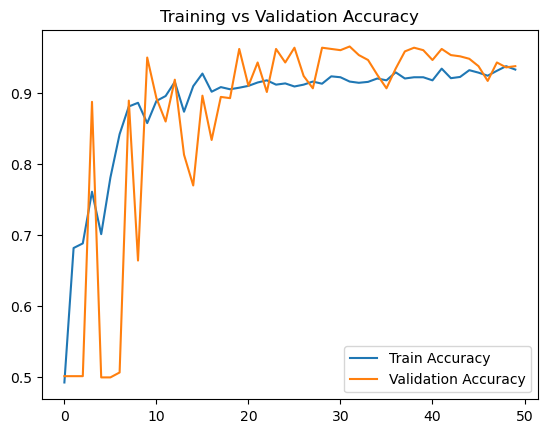

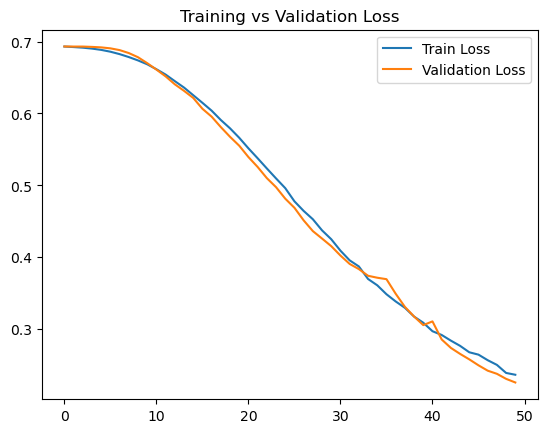

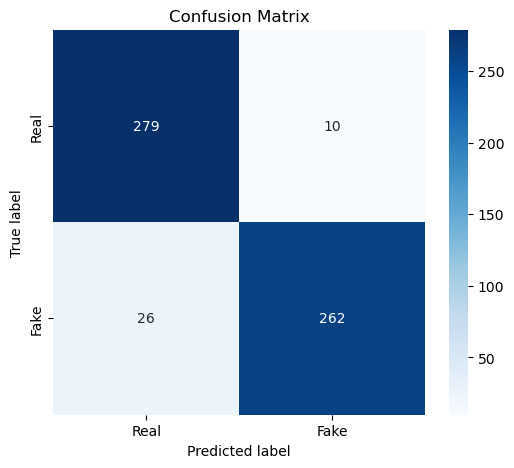

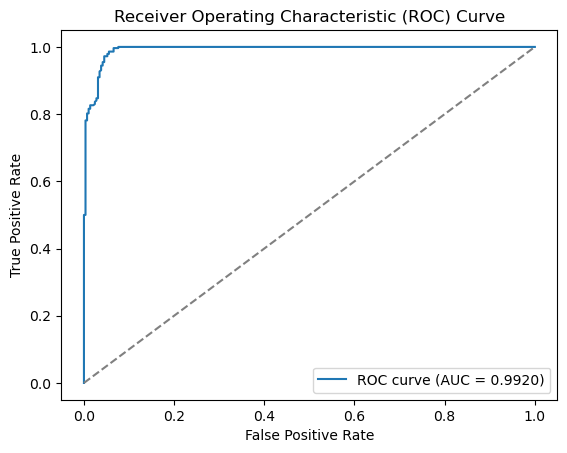

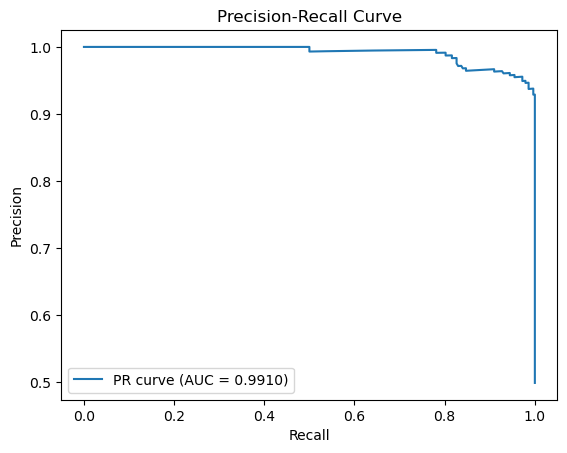

Accuracy Score: 0.9376
ROC AUC Score: 0.9920
Recall Score: 0.9097
Precision Score: 0.9632
F1 Score: 0.9357
PR AUC Score: 0.9910
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       289
           1       0.96      0.91      0.94       288

    accuracy                           0.94       577
   macro avg       0.94      0.94      0.94       577
weighted avg       0.94      0.94      0.94       577



In [5]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# Train the Model
train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=50, batch_size=32)

In [68]:
import os
import shutil

# Source and destination directories
source_dir = "E:/Research/real/Cropped_Faces"
destination_dir = "E:/dataset/real"

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Valid image extensions
image_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff"}

def move_images(src, dest):
    for root, _, files in os.walk(src):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                src_file = os.path.join(root, file)
                dest_file = os.path.join(dest, file)
                
                # Ensure unique filenames if duplicates exist
                counter = 1
                while os.path.exists(dest_file):
                    name, ext = os.path.splitext(file)
                    dest_file = os.path.join(dest, f"{name}_{counter}{ext}")
                    counter += 1
                
                shutil.move(src_file, dest_file)
                print(f"Moved: {src_file} -> {dest_file}")

# Execute the function
move_images(source_dir, destination_dir)

print("Image moving process completed.")


Moved: E:/Research/real/Cropped_Faces\M004_light_up_angry_camera_front\frame_0000_face_00.jpg -> E:/dataset/real\frame_0000_face_00.jpg
Moved: E:/Research/real/Cropped_Faces\M004_light_up_angry_camera_front\frame_0001_face_00.jpg -> E:/dataset/real\frame_0001_face_00.jpg
Moved: E:/Research/real/Cropped_Faces\M004_light_up_angry_camera_front\frame_0002_face_00.jpg -> E:/dataset/real\frame_0002_face_00.jpg
Moved: E:/Research/real/Cropped_Faces\M004_light_up_angry_camera_front\frame_0003_face_00.jpg -> E:/dataset/real\frame_0003_face_00.jpg
Moved: E:/Research/real/Cropped_Faces\M004_light_up_angry_camera_front\frame_0004_face_00.jpg -> E:/dataset/real\frame_0004_face_00.jpg
Moved: E:/Research/real/Cropped_Faces\M004_light_up_angry_camera_front\frame_0005_face_00.jpg -> E:/dataset/real\frame_0005_face_00.jpg
Moved: E:/Research/real/Cropped_Faces\M004_light_up_angry_camera_front\frame_0006_face_00.jpg -> E:/dataset/real\frame_0006_face_00.jpg
Moved: E:/Research/real/Cropped_Faces\M004_light

KeyboardInterrupt: 

In [1]:
import os

def count_videos(root_dir, check_angry=False):
    """
    Counts the number of video files (.mp4 and .avi) in the directory tree.

    Args:
        root_dir (str): The root directory to traverse.
        check_angry (bool): If True, only count videos in folders with "angry" in their path.

    Returns:
        int: The total count of video files found.
    """
    video_extensions = ('.mp4', '.avi')
    count = 0

    for root, _, files in os.walk(root_dir):
        # If checking for 'angry', skip folders that don't have 'angry' in their path.
        if check_angry and "angry" not in root.lower():
            continue

        for file in files:
            if file.lower().endswith(video_extensions):
                count += 1

    return count

if __name__ == "__main__":
    # Define your root directories
    real_videos_dir = "F:/dataset/DeeperForensics-1.0/source_videos"
    fake_videos_dir = "F:/dataset/DeeperForensics-1.0/manipulated_videos/end_to_end"
    
    

    # Count videos in each directory
    real_videos_count = count_videos(real_videos_dir, True)
    fake_videos_count = count_videos(fake_videos_dir, False)
    
    # Print the counts
    print(f"Total number of real videos: {real_videos_count}")
    print(f"Total number of fake videos: {fake_videos_count}")


Total number of real videos: 5948
Total number of fake videos: 1000
